In [1]:
%load_ext autoreload
%autoreload 2

In [45]:
import sys

sys.path.append("..")

from typing import NamedTuple

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import Array, jit

# OOP style

In [12]:
class Bandit:
    def select_action(key: Array, state: NamedTuple) -> Array: ...

    def update(state: NamedTuple, action: int, reward: float) -> NamedTuple: ...


class EpsilonGreedyState(NamedTuple):
    epsilon: float
    values: Array
    counts: Array


class EpsilonGreedy(Bandit):
    @staticmethod
    @jit
    def select_action(key: Array, state: EpsilonGreedyState) -> Array:
        key, subkey = jax.random.split(key)
        num_actions = state.values.shape[0]

        def explore():
            return jax.random.randint(subkey, shape=(), minval=0, maxval=num_actions)

        def exploit():
            return jnp.argmax(state.values)

        return jax.lax.cond(
            jax.random.uniform(key) < state.epsilon,
            explore,
            exploit,
        )

    @staticmethod
    @jit
    def update(state: EpsilonGreedyState, action: int, reward: float) -> EpsilonGreedyState:
        counts, values = state.counts, state.values

        counts_update = counts[action] + 1
        values_update = values[action] + (reward - values[action]) / counts_update

        counts = counts.at[action].set(counts_update)
        values = values.at[action].set(values_update)

        return EpsilonGreedyState(state.epsilon, values, counts)


class ThomsonSamplingState(NamedTuple):
    alpha: Array
    beta: Array


class ThomsonSampling(Bandit):
    @staticmethod
    @jit
    def select_action(key: Array, state: ThomsonSamplingState) -> Array:
        expected_rewards = jax.random.beta(key, state.alpha, state.beta)

        return jnp.argmax(expected_rewards)

    @staticmethod
    @jit
    def update(state: ThomsonSamplingState, action: int, reward: float) -> ThomsonSamplingState:
        alpha, beta = state.alpha, state.beta

        alpha_update = alpha[action] + reward
        beta_update = beta[action] + (1.0 - reward)

        alpha = alpha.at[action].set(alpha_update)
        beta = beta.at[action].set(beta_update)

        return ThomsonSamplingState(alpha, beta)

In [13]:
class Environment:
    def __init__(self, true_rewards: Array) -> None:
        self.true_rewards = true_rewards

    def run(self, key: Array, bandit: Bandit, init_state: NamedTuple, num_steps: int) -> tuple[NamedTuple, Array]:
        @jit
        def step(carry: tuple[NamedTuple, Array], key: Array) -> tuple[NamedTuple, Array]:
            bandit_state, true_rewards = carry
            key, subkey = jax.random.split(key)

            action = bandit.select_action(key, bandit_state)

            reward = jax.random.bernoulli(subkey, true_rewards[action]).astype(jnp.float32)

            bandit_state = bandit.update(bandit_state, action, reward)

            return (bandit_state, true_rewards), reward

        keys = jax.random.split(key, num_steps)
        (state, _), rewards = jax.lax.scan(step, (init_state, self.true_rewards), keys)

        return state, rewards

In [14]:
key = jax.random.key(1234)
num_actions = 10

key, subkey = jax.random.split(key)

true_probas = jax.random.uniform(subkey, num_actions)
env = Environment(true_probas)

In [22]:
greedy = EpsilonGreedy()
greedy_init_state = EpsilonGreedyState(
    epsilon=0.1,
    values=jnp.zeros(num_actions),
    counts=jnp.zeros(num_actions),
)

key, subkey = jax.random.split(key)

In [23]:
%%timeit
greedy_state, greedy_rewards = env.run(key, greedy, greedy_init_state, num_steps=10_000)

159 ms ± 8.49 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [159]:
ts = ThomsonSampling()
ts_init_state = ThomsonSamplingState(
    alpha=jnp.ones(num_actions),
    beta=jnp.ones(num_actions),
)

key, subkey = jax.random.split(key)
ts_state, ts_rewards = env.run(key, ts, ts_init_state, num_steps=10_000)

print(ts_rewards.mean())

0.9873


# Functional

In [169]:
from src.bandits import environment
from src.bandits.policies import epsilon_greedy, thomson_sampling, ucb

key = jax.random.key(1234)

num_actions = 10
num_steps = 10_000
num_iter = 100

key, subkey = jax.random.split(key)
true_rewards = jax.random.uniform(subkey, num_actions)

greedy_init_state = epsilon_greedy.EpsilonGreedyState(
    epsilon=0.1,
    values=jnp.zeros(num_actions),
    counts=jnp.zeros(num_actions),
)

ucb_init_state = ucb.UCBState(
    c=1.0,
    steps=0.0,
    values=jnp.zeros(num_actions),
    counts=jnp.zeros(num_actions),
)

ts_init_state = thomson_sampling.ThomsonSamplingState(
    alphas=jnp.ones(num_actions),
    betas=jnp.ones(num_actions),
)

key, key_greedy, key_ucb, key_ts = jax.random.split(key, 4)

keys_greedy = jax.random.split(key_greedy, num_steps * num_iter).reshape(num_iter, num_steps)
greedy_state, greedy_rewards = environment.simulate_multiple(
    keys_greedy,
    true_rewards,
    epsilon_greedy.select_action,
    epsilon_greedy.update_state,
    greedy_init_state,
)

keys_ucb = jax.random.split(key_ucb, num_steps * num_iter).reshape(num_iter, num_steps)
ucb_state, ucb_rewards = environment.simulate_multiple(
    keys_greedy,
    true_rewards,
    ucb.select_action,
    ucb.update_state,
    ucb_init_state,
)

keys_ts = jax.random.split(key_ts, num_steps * num_iter).reshape(num_iter, num_steps)
ts_state, ts_rewards = environment.simulate_multiple(
    keys_ts,
    true_rewards,
    thomson_sampling.select_action,
    thomson_sampling.update_state,
    ts_init_state,
)

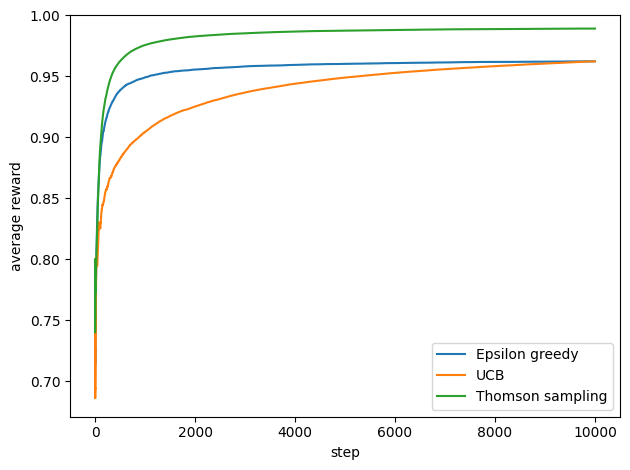

In [154]:
_, ax = plt.subplots()

step_inds = jnp.arange(1, num_steps + 1)

ax.plot(jnp.cumsum(jnp.mean(greedy_rewards, axis=0)) / step_inds, label="Epsilon greedy")
ax.plot(jnp.cumsum(jnp.mean(ucb_rewards, axis=0)) / step_inds, label="UCB")
ax.plot(jnp.cumsum(jnp.mean(ts_rewards, axis=0)) / step_inds, label="Thomson sampling")
ax.set_xlabel("step")
ax.set_ylabel("average reward")
ax.set_ylim(top=1.0)
plt.legend()
plt.tight_layout()

In [168]:
key = jax.random.key(1234)
key, subkey = jax.random.split(key)